In [8]:
import pandas as pd
import numpy as np
import missingno as mn

import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

import glob
import os

import abc
import numpy as np

import pandas as pd
import abc
import re
import nltk
from sklearn import model_selection 
%matplotlib inline

In [9]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

In [6]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

## Merge News dataset

In [2]:
pathOfCwd = os.getcwd()
pathOfCwd
NewsFolder = r'\\MicrosoftNews\\' # use your path
path = pathOfCwd +NewsFolder
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

## Remove rows with nan

In [3]:
frame.dropna(inplace=True, axis='rows')

## Construction of dataframe

In [4]:
df = frame.copy()

In [5]:
df['HNA_combine'] = df['Headline'].map(str) + ' ' + df['NewsAbstract'].map(str) 

In [6]:
df.drop(['Headline','NewsAbstract'], axis=1, inplace= True)

In [5]:
tempProcessedList = list()
for s in df['HNA_combine'].values.tolist():
    tempProcessedList = " ".join(text_processor.pre_process_doc(s))
    
df['HNA_combine'] = tempProcessedList

## loughran and mcdonald financial sentiment dictionary

In [7]:
# code taken from -https://github.com/hanzhichao2000/pysentiment
#as pysentiment was not required in full, hence handy functions from library are taken for creating featured engineered dataset.


class BaseTokenizer(object, metaclass=abc.ABCMeta):
    """
    An abstract class for tokenize text.
    """

    @abc.abstractmethod
    def tokenize(self, text):
        """Return tokenized temrs.
        
        :type text: str
        
        :returns: list 
        """
        pass
    
class Tokenizer(BaseTokenizer):
    """
    The default tokenizer for ``pysentiment``, which only takes care of words made up of ``[a-z]+``.
    The output of the tokenizer is stemmed by ``nltk.PorterStemmer``. 
    
    The stoplist from https://www3.nd.edu/~mcdonald/Word_Lists.html is included in this
    tokenizer. Any word in the stoplist will be excluded from the output.
    """
    
    def __init__(self):
        self._stemmer = nltk.PorterStemmer()
        self._stopset = self.get_stopset()
        
    def tokenize(self, text):
        tokens = []
        for t in nltk.regexp_tokenize(text.lower(), '[a-z]+'):
            t = self._stemmer.stem(t)
            if not t in self._stopset:
                tokens.append(t)
        return tokens
        
    def get_stopset(self):
        STATIC_PATH = os.getcwd()+'/static'
        files = ['Currencies.txt', 'DatesandNumbers.txt', 'Generic.txt', 'Geographic.txt',
                 'Names.txt']
        stopset = set()
        for f in files:
            fin = open('%s/%s'%(STATIC_PATH, f), 'rb')
            for line in fin.readlines():
                line = line.decode(encoding='latin-1')
                match = re.search('(\w+)', line)
                if match == None:
                    continue
                word = match.group(1)
                stopset.add(self._stemmer.stem(word.lower()))
            fin.close()
        return stopset



STATIC_PATH = os.getcwd()+'/static'


class BaseDict(object):
    """
    A base class for sentiment analysis. 
    For now, only 'positive' and 'negative' analysis is supported.
    
    Subclasses should implement ``init_dict``, 
    in which ``_posset`` and ``_negset`` are initialized.
    
    ``Polarity`` and ``Subjectivity`` are calculated in the same way of Lydia system.
    See also http://www.cs.sunysb.edu/~skiena/lydia/
    
    The formula for ``Polarity`` is,
    
    .. math::
    
        Polarity= \\frac{N_{pos}-N_{neg}}{N_{pos}+N_{neg}}
    
    The formula for ``Subjectivity`` is,
    
    .. math::
    
        Subjectivity= \\frac{N_{pos}+N_{neg}}{N}
    
    :type tokenizer: obj    
    :param tokenizer: An object which provides interface of ``tokenize``. 
        If it is ``None``, a default tokenizer, which is defined in ``utils``, will be assigned.
    """
    
    __metaclass__ = abc.ABCMeta

    TAG_POL = 'Polarity'
    TAG_SUB = 'Subjectivity'
    TAG_POS = 'Positive'
    TAG_NEG = 'Negative'
    
    EPSILON = 1e-6
    
    def __init__(self, tokenizer=None):
        self._posset = set()
        self._negset = set()
        if tokenizer is None:
            self._tokenizer = Tokenizer()
        else:
            self._tokenizer = tokenizer
        self.init_dict()
        
        assert len(self._posset) > 0 and len(self._negset) > 0
        
    def tokenize(self, text):
        """
        :type text: str
        :returns: list
        """

        return self._tokenizer.tokenize(text)

    def tokenize_first(self, x):
        """
        :type x: str
        :returns: str
        """
        tokens = self.tokenize(x)
        if tokens:
            return tokens[0]
        else:
            return None

    @abc.abstractmethod
    def init_dict(self):
        pass
    
    def _get_score(self, term):
        """Get score for a single term.

        - +1 for positive terms.
        - -1 for negative terms.
        - 0 for others. 
        
        :returns: int
        """
        if term in self._posset:
            return +1
        elif term in self._negset:
            return -1
        else:
            return 0
        
    def get_score(self, terms):
        """Get score for a list of terms.
        
        :type terms: list
        :param terms: A list of terms to be analyzed.
        
        :returns: dict
        """
        assert isinstance(terms, list) or isinstance(terms, tuple)
        score_li = np.asarray([self._get_score(t) for t in terms])
        
        s_pos = np.sum(score_li[score_li > 0])
        s_neg = -np.sum(score_li[score_li < 0])
        
        s_pol = (s_pos-s_neg) * 1.0 / ((s_pos+s_neg)+self.EPSILON)
        s_sub = (s_pos+s_neg) * 1.0 / (len(score_li)+self.EPSILON)
        
        return {self.TAG_POS: s_pos,
                self.TAG_NEG: s_neg,
                self.TAG_POL: s_pol,
                self.TAG_SUB: s_sub}

import pandas as pd

class HIV4(BaseDict):
    """
    Dictionary class for Harvard IV-4. 
    See also http://www.wjh.harvard.edu/~inquirer/
    
    The terms for the dictionary are stemmed by the default tokenizer.
    """
    
    PATH = '%s/HIV-4.csv' % STATIC_PATH
    
    def init_dict(self):
        data = pd.read_csv(self.PATH, dtype='category')
        self._posset = set(data.query('Positiv == "Positiv"')['Entry'].apply(self.tokenize_first).dropna())
        self._negset = set(data.query('Negativ == "Negativ"')['Entry'].apply(self.tokenize_first).dropna())
        
class LM(BaseDict):
    """
    Dictionary class for
    Loughran and McDonald Financial Sentiment Dictionaries.
    
    See also https://www3.nd.edu/~mcdonald/Word_Lists.html
    
    The terms for the dictionary are stemmed by the default tokenizer.
    """
    
    PATH = '%s/LM.csv' % STATIC_PATH
    
    def init_dict(self):
        data = pd.read_csv(self.PATH)
        self._posset = set(data.query('Positive > 0')['Word'].apply(self.tokenize_first).dropna())
        self._negset = set(data.query('Negative > 0')['Word'].apply(self.tokenize_first).dropna())



In [8]:
hiv4 = HIV4()
def get_hiv4_score(text):
    tokens = hiv4.tokenize(text)
    hiv4_score = hiv4.get_score(tokens)
    return hiv4_score

In [9]:
def get_textblob_score(text):
    return TextBlob(text).sentiment

In [10]:
lm = LM()
def get_lm_score(text):
    tokens = lm.tokenize(text)
    lm_score = lm.get_score(tokens)
    return lm_score

In [11]:
df['news_len'] = df['HNA_combine'].apply(lambda x: len(x))

In [12]:
# building list LM dictionary
positive =[]
negative =[]
polarity =[]
subjectivity =[]

for text in df.HNA_combine:
    z=  get_lm_score(text)
    positive.append(z['Positive'])
    negative.append(z['Negative'])
    polarity.append(z['Polarity'])
    subjectivity.append(z['Subjectivity'])
df['lm_positive'] = positive
df['lm_negative'] = negative
df['lm_polarity'] = polarity
df['lm_subjectivity'] = subjectivity

In [13]:
# building list textBlob
polarity =[]
subjectivity =[]

for text in df.HNA_combine:
    z=  get_textblob_score(text)
    polarity.append(z.polarity)
    subjectivity.append(z.subjectivity)
df['tb_polarity'] = polarity
df['tb_subjectivity'] = subjectivity

In [14]:
# building list hiv4
positive =[]
negative =[]
polarity =[]
subjectivity =[]

for text in df.HNA_combine:
    z=  get_hiv4_score(text)
    positive.append(z['Positive'])
    negative.append(z['Negative'])
    polarity.append(z['Polarity'])
    subjectivity.append(z['Subjectivity'])
df['hiv4_positive'] = positive
df['hiv4_negative'] = negative
df['hiv4_polarity'] = polarity
df['hiv4_subjectivity'] = subjectivity

## Processing 2 - Lexicon

In [15]:
from nltk.tokenize import RegexpTokenizer

In [16]:
df_lexicons = pd.read_csv("lexicons_compiled.csv")

In [17]:
l_trust =(df_lexicons.loc[df_lexicons['emotion'] == 'trust'])['word'].values.tolist()
l_fear =(df_lexicons.loc[df_lexicons['emotion'] == 'fear'])['word'].values.tolist()
l_anger =(df_lexicons.loc[df_lexicons['emotion'] == 'anger'])['word'].values.tolist()
l_disgust =(df_lexicons.loc[df_lexicons['emotion'] == 'disgust'])['word'].values.tolist()
l_sadness =(df_lexicons.loc[df_lexicons['emotion'] == 'sadness'])['word'].values.tolist()
l_surprise =(df_lexicons.loc[df_lexicons['emotion'] == 'surprise'])['word'].values.tolist()
l_joy =(df_lexicons.loc[df_lexicons['emotion'] == 'joy'])['word'].values.tolist()
l_anticipation =(df_lexicons.loc[df_lexicons['emotion'] == 'anticipation'])['word'].values.tolist()

In [18]:
tknzr = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [19]:
df['HNA_combine'] = df['HNA_combine'].apply(lambda x: tknzr.tokenize(x))

In [20]:
df.reset_index(inplace=True)

In [21]:
newsList = df.HNA_combine.values.tolist()

In [22]:
def getEmotionsCount(tokenisedSentence, emotionDictionary):
    counter =0
    for word in tokenisedSentence:
        if word in emotionDictionary:
            counter = counter +1
    return counter

In [23]:
def prepareEmotionsList(tokenisedList,df):
    res1 = list()
    res2 = list()
    res3 = list()
    res4 = list()
    res5 = list()
    res6 = list()
    res7 = list()
    res8 = list()
    counter = 0
    for sentence in tokenisedList:
        
        date = df.Date[counter]
        totalDocuments = len((df.loc[df['Date'] == date]))
        
        res1.append((getEmotionsCount(sentence, l_trust)/ len(sentence))/totalDocuments)
        res2.append((getEmotionsCount(sentence, l_fear)/ len(sentence))/totalDocuments)
        res3.append((getEmotionsCount(sentence, l_anger)/ len(sentence))/totalDocuments)
        res4.append((getEmotionsCount(sentence, l_disgust)/ len(sentence))/totalDocuments)
        res5.append((getEmotionsCount(sentence, l_sadness)/ len(sentence))/totalDocuments)
        res6.append((getEmotionsCount(sentence, l_surprise)/ len(sentence))/totalDocuments)
        res7.append((getEmotionsCount(sentence, l_joy)/ len(sentence))/totalDocuments)
        res8.append((getEmotionsCount(sentence, l_anticipation)/ len(sentence))/totalDocuments)
        counter = counter +1
        
    return res1, res2, res3, res4, res5, res6, res7, res8

In [24]:
result = prepareEmotionsList(newsList,df)

In [25]:
data_tuples = list(zip(result[0],result[1],result[2],result[3],result[4],result[5],result[6],result[7]))

In [26]:
data_tuples =  pd.DataFrame(data_tuples, columns=['trust','fear','anger','disgust','sadness','suprise', 'joy', 'anticipation'])

## Identification of orientation

In [27]:
l_passive =(df_lexicons.loc[df_lexicons['orientation'] == 'passive'])['word'].values.tolist()
l_active =(df_lexicons.loc[df_lexicons['orientation'] == 'active'])['word'].values.tolist()

In [28]:
def getOrientationCount(tokenisedSentence, orientationDictionary):
    counter =0
    for word in tokenisedSentence:
        if word in orientationDictionary:
            counter = counter +1
    return counter

In [29]:
def prepareOrientationList(tokenisedList):
    res1 = list()
    res2 = list()
    
    for sentence in tokenisedList:
        res1.append(getOrientationCount(sentence, l_passive))
        res2.append(getOrientationCount(sentence, l_active))
        
    return res1, res2

In [30]:
result2 = prepareOrientationList(newsList)

In [31]:
data_tuples_2 = list(zip(result2[0],result2[1]))
data_tuples_2 =  pd.DataFrame(data_tuples_2, columns=['passive','active'])
data_tuples_2.head(2)

,passive,active
0,0,6
1,0,0


## Identification of subjectivity

In [32]:
l_weak =(df_lexicons.loc[df_lexicons['subjectivity'] == 'weak'])['word'].values.tolist()
l_strong =(df_lexicons.loc[df_lexicons['subjectivity'] == 'strong'])['word'].values.tolist()

In [33]:
def getSubjectivityCount(tokenisedSentence, subjectivityDictionary):
    counter =0
    for word in tokenisedSentence:
        if word in subjectivityDictionary:
            counter = counter +1
    return counter

In [34]:
def prepareSubjectivityList(tokenisedList):
    res1 = list()
    res2 = list()
    
    for sentence in tokenisedList:
        res1.append(getSubjectivityCount(sentence, l_weak))
        res2.append(getSubjectivityCount(sentence, l_strong))
        
    return res1, res2

In [35]:
result3 = prepareSubjectivityList(newsList)

In [36]:
data_tuples_3 = list(zip(result3[0],result3[1]))
data_tuples_3 =  pd.DataFrame(data_tuples_3, columns=['weak','strong'])
data_tuples_3.head(2)

,weak,strong
0,2,3
1,1,0


In [37]:
df['actvie'] = data_tuples_2.active.values.tolist()
df['passive'] = data_tuples_2.passive.values.tolist()

In [38]:
df['weak'] = data_tuples_3.weak.values.tolist()
df['strong'] = data_tuples_3.strong.values.tolist()

In [39]:
df['anger'] = data_tuples.anger.values.tolist()
df['joy'] = data_tuples.joy.values.tolist()
df['suprise'] = data_tuples.suprise.values.tolist()
df['sadness'] = data_tuples.sadness.values.tolist()
df['disgust'] = data_tuples.disgust.values.tolist()
df['anticipation'] = data_tuples.anticipation.values.tolist()
df['fear'] = data_tuples.fear.values.tolist()
df['trust'] = data_tuples.trust.values.tolist()

In [40]:
df['HNA_combine_sent'] = df['HNA_combine'].apply(lambda x: ' '.join(x))

In [41]:
dfz = df.groupby(['Date']).agg({'news_len':'sum','lm_positive':'sum', 'HNA_combine_sent':'-'.join,'lm_negative':'sum','lm_polarity':'sum','lm_subjectivity':'sum','actvie':'sum','passive':'sum','weak':'sum','strong':'sum','anger':'sum','joy':'sum','suprise':'sum','sadness':'sum','disgust':'sum','anticipation':'sum','fear':'sum','trust':'sum','tb_polarity':'sum','tb_subjectivity':'sum','hiv4_positive':'sum','hiv4_negative':'sum','hiv4_polarity':'sum','hiv4_subjectivity':'sum'}).reset_index()

In [42]:
dfz['anger'] = (dfz['anger']/ dfz['news_len'])
dfz['joy'] =(dfz['joy']/ dfz['news_len'])
dfz['suprise'] = (dfz['suprise']/ dfz['news_len'])
dfz['sadness'] =(dfz['sadness']/ dfz['news_len'])
dfz['anticipation'] =(dfz['anticipation']/dfz['news_len'])
dfz['fear'] =(dfz['fear']/ dfz['news_len'])
dfz['trust'] = (dfz['trust']/ dfz['news_len'])

## Date Consistency

In [43]:
from dateutil.parser import parse
from matplotlib import pyplot
import datetime

In [44]:
dfz['Date'] = dfz['Date'].apply(lambda x: (parse(x).strftime('%Y/%m/%d')))

In [45]:
dfz.rename(columns={'Date':'date'}, inplace=True)

## Adding lagged data

In [46]:
df_sp_MSFT = pd.read_csv('MSFT.csv')

In [47]:
startDate = str(min(dfz['date']))
endDate = str(max(dfz['date']))

In [48]:
print(startDate)
print(endDate)

2004/07/21
2019/03/28


In [49]:
df_sp_MSFT.rename(columns={'Date': 'date'}, inplace=True)
df_sp_MSFT.rename(columns={'Close': 'close'}, inplace=True)
df_sp_MSFT['date'] = df_sp_MSFT['date'].apply(
    lambda x: (parse(x).strftime('%Y/%m/%d')))

In [50]:
start = datetime.datetime.strptime(startDate, "%Y/%m/%d")
end = datetime.datetime.strptime(
    endDate, "%Y/%m/%d") + datetime.timedelta(days=8)  # adding two day buffers
date_generated = [(start + datetime.timedelta(days=x)).strftime('%Y/%m/%d')
                  for x in range(0, (end-start).days)]

In [51]:
generated_date_df = pd.DataFrame({'date': date_generated})
generated_date_df['date'] = generated_date_df['date'].apply(
    lambda x: (parse(x).strftime('%Y/%m/%d')))

result = pd.merge(df_sp_MSFT,
                  generated_date_df,
                  on='date',
                  how='right')

result = result.ix[pd.to_datetime(result.date).sort_values().index]
result_ = result.fillna(method='ffill')

C:\Users\praveen ji\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


In [52]:
listUpOrDown1 = list()
listUpOrDown2 = list()
listUpOrDown3 = list()
listUpOrDown4 = list()

In [53]:
datesIntrestedIn = list(set(dfz.date.tolist()))
for date in datesIntrestedIn:
        select_indices = list(np.where(result_["date"] == date)[0])[0]
        listUpOrDown1.append(1 if (
            (result_.iloc[select_indices+1]['close'] - result_.iloc[select_indices]['close']) > 0) else 0)
        listUpOrDown2.append(1 if (
            (result_.iloc[select_indices+2]['close'] - result_.iloc[select_indices]['close']) > 0) else 0)
        listUpOrDown3.append(1 if (
            (result_.iloc[select_indices+3]['close'] - result_.iloc[select_indices]['close']) > 0) else 0)
        listUpOrDown4.append(1 if (
            (result_.iloc[select_indices+4]['close'] - result_.iloc[select_indices]['close']) > 0) else 0)

In [54]:
dfz['Lag1'] = listUpOrDown1
dfz['Lag2'] = listUpOrDown2
dfz['Lag3'] = listUpOrDown3
dfz['Lag4'] = listUpOrDown4

In [55]:
dfz.head(2)

,date,news_len,lm_positive,HNA_combine_sent,lm_negative,lm_polarity,lm_subjectivity,actvie,passive,weak,...,tb_polarity,tb_subjectivity,hiv4_positive,hiv4_negative,hiv4_polarity,hiv4_subjectivity,Lag1,Lag2,Lag3,Lag4
0,2005/04/01,493,1,On Asia : Why big is not really better ...shar...,2,-0.999999,0.158730,8,4,5,...,0.245671,0.745887,4,2,0.666666,0.309524,0,0,0,0
1,2004/12/01,931,0,Lex : Sage ...strong growth and margins compar...,3,-1.000000,0.176471,17,2,6,...,0.375433,1.305411,10,5,1.633333,0.906629,0,0,0,0


In [56]:
def getStats(df):
    S_stats =list()
    Laglist = ['Lag1','Lag2','Lag3','Lag4']
    for lagCol in Laglist:
        print("For: ", lagCol)
        S_stats.append(('down',df[lagCol].values.tolist().count(0)))
        S_stats.append(('up',df[lagCol].values.tolist().count(1)))
        labels, ys = zip(*S_stats)
        xs = np.arange(len(labels)) 
        width = 1

        plt.bar(xs, ys, width, align='center')

        plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
        plt.yticks(ys)
        plt.show()

For:  Lag1


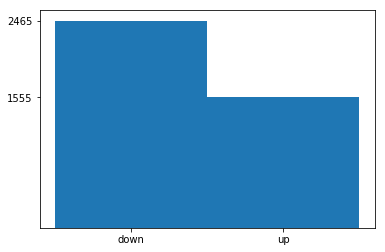

For:  Lag2


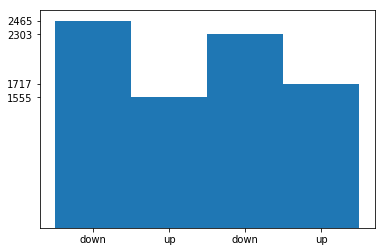

For:  Lag3


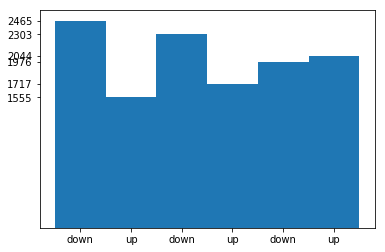

For:  Lag4


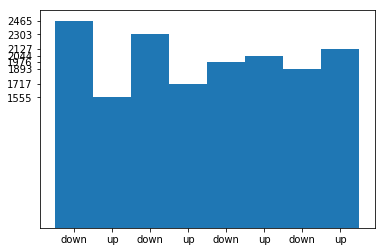

In [57]:
getStats(dfz)

In [58]:
#taking out target columns
LagDF = dfz[dfz.columns[-4:]]
LagDF.to_csv('nw_lag_MSFT.csv',index=False, index_label=None)

In [59]:
#taking out fetures columns
FeatureDF = dfz[dfz.columns[:-4]]
FeatureDF.to_csv('nw_feature_MSFT.csv',index=False, index_label=None)

In [60]:
#taking out fetures columns
FeatureDF.drop(columns=['HNA_combine_sent'],inplace=True)
FeatureDF.to_csv('nw_feature_woText_MSFT.csv',index=False, index_label=None)

C:\Users\praveen ji\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Loading Data for Model Building

In [109]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [110]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import datetime
import missingno as mn
import pylab as plt
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
featureDF_ = pd.read_csv('nw_feature_woText_MSFT.csv')
targetDF_ = pd.read_csv('nw_lag_MSFT.csv')


In [112]:
featureDF_.drop(columns=['date'],inplace=True)

In [113]:
featureDF_.head()

,lm_positive,lm_negative,lm_polarity,lm_subjectivity,actvie,passive,weak,strong,anger,joy,...,disgust,anticipation,fear,trust,tb_polarity,tb_subjectivity,hiv4_positive,hiv4_negative,hiv4_polarity,hiv4_subjectivity
0,1,2,-0.999999,0.158730,8,4,5,7,0.010870,0.0,...,0.0,0.021739,0.000000,0.000000,0.245671,0.745887,4,2,0.666666,0.309524
1,0,3,-1.000000,0.176471,17,2,6,3,0.005319,0.0,...,0.0,0.027526,0.000000,0.011417,0.375433,1.305411,10,5,1.633333,0.906629
2,2,2,0.666666,0.247619,19,5,12,5,0.003106,0.0,...,0.0,0.013293,0.003247,0.016244,1.209785,2.908081,18,11,2.799999,1.479092
3,0,1,-0.999999,0.071429,11,1,5,1,0.012195,0.0,...,0.0,0.022727,0.011364,0.011364,0.483333,1.266667,3,3,0.000000,0.357143
4,3,2,0.333333,0.234450,9,1,9,2,0.014815,0.0,...,0.0,0.007576,0.000000,0.007407,0.335290,1.377374,10,5,1.000000,0.717703


In [114]:
def plotImportanceOfFeature(features,clf):
    importances = clf.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [115]:
def corelationPlot (df_):
    corr = df_.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(df_.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(df_.columns)
    ax.set_yticklabels(df_.columns)
    plt.show()

C:\Users\praveen ji\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


['hiv4_subjectivity']


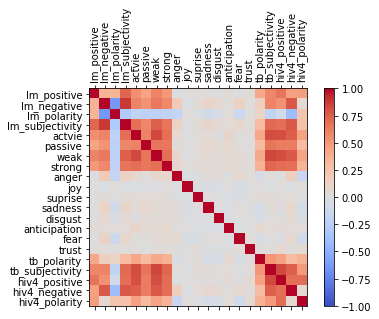

['lm_subjectivity']


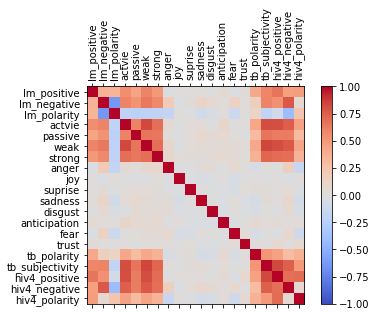

['hiv4_positive']


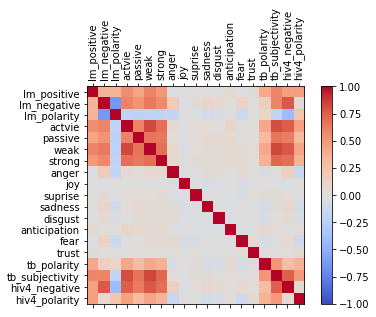

['hiv4_negative']


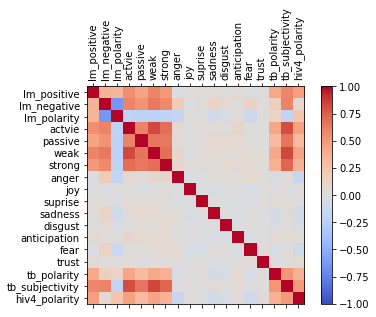

['tb_subjectivity']


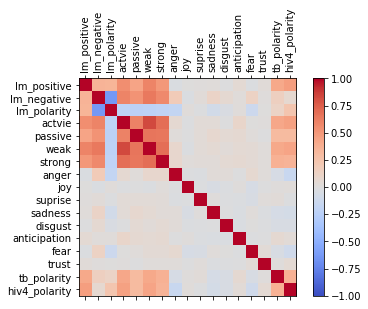

['weak']


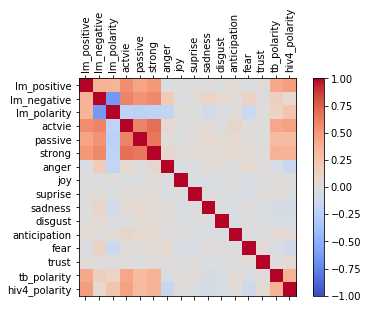

['lm_negative']


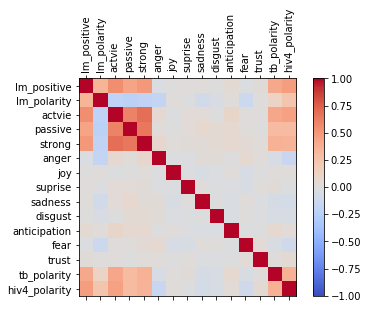

In [116]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(featureDF_.values, i) for i in range(featureDF_.values.shape[1])]
vif.round(1)
while max(vif["VIF Factor"])>10:
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(featureDF_.values, i) for i in range(featureDF_.values.shape[1])]
    vif.round(1)
    dropCol = [featureDF_.columns[np.argmax(vif["VIF Factor"])]]
    print(dropCol)
    featureDF_.drop(columns=dropCol, inplace=True)
    corelationPlot (featureDF_)

In [117]:
def computerConfusionMatrixAndAccuracy(featureDF , targetDF, features):
    for index in list(targetDF):
        train_features, test_features, train_labels, test_labels= model_selection.train_test_split( featureDF , targetDF[index], test_size=0.1, random_state=0)

        rf_model =RandomForestClassifier(n_estimators=5000, max_depth=4,random_state=0)
        rf_model.fit(train_features, train_labels)
        y_predicted=rf_model.predict(test_features)
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++' )
        print('For Lag:', index)
        
        plotImportanceOfFeature(features, rf_model)
        print('confusion_matrix',confusion_matrix(y_true=test_labels, y_pred=y_predicted))
        print('number of datapoints in Up Class', test_labels.value_counts()[1])
        print('number of datapoints in Down Class', test_labels.value_counts()[0])
        print('accuracy_score',accuracy_score(y_predicted, test_labels))
        print('classification_score\n',classification_report(y_predicted, test_labels))
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Lag: Lag1


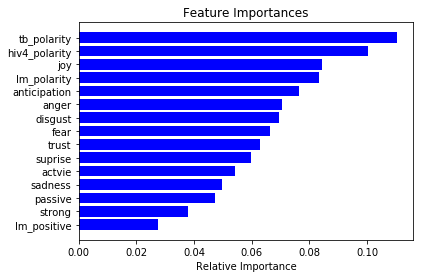

confusion_matrix [[235   0]
 [167   0]]
number of datapoints in Up Class 167
number of datapoints in Down Class 235
accuracy_score 0.5845771144278606
classification_score
               precision    recall  f1-score   support

           0       1.00      0.58      0.74       402
           1       0.00      0.00      0.00         0

   micro avg       0.58      0.58      0.58       402
   macro avg       0.50      0.29      0.37       402
weighted avg       1.00      0.58      0.74       402

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Lag: Lag2


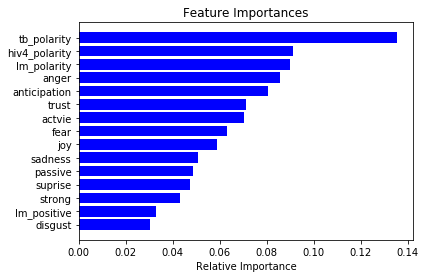

confusion_matrix [[223   0]
 [179   0]]
number of datapoints in Up Class 179
number of datapoints in Down Class 223
accuracy_score 0.554726368159204
classification_score
               precision    recall  f1-score   support

           0       1.00      0.55      0.71       402
           1       0.00      0.00      0.00         0

   micro avg       0.55      0.55      0.55       402
   macro avg       0.50      0.28      0.36       402
weighted avg       1.00      0.55      0.71       402

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Lag: Lag3


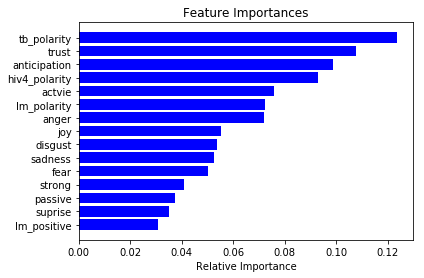

confusion_matrix [[ 65 128]
 [ 81 128]]
number of datapoints in Up Class 209
number of datapoints in Down Class 193
accuracy_score 0.48009950248756217
classification_score
               precision    recall  f1-score   support

           0       0.34      0.45      0.38       146
           1       0.61      0.50      0.55       256

   micro avg       0.48      0.48      0.48       402
   macro avg       0.47      0.47      0.47       402
weighted avg       0.51      0.48      0.49       402

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Lag: Lag4


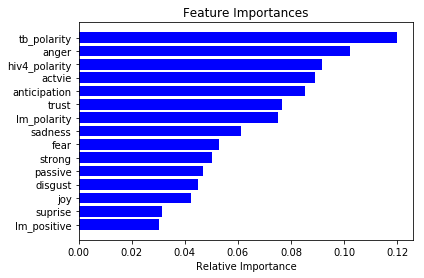

confusion_matrix [[  6 190]
 [  9 197]]
number of datapoints in Up Class 206
number of datapoints in Down Class 196
accuracy_score 0.5049751243781094
classification_score
               precision    recall  f1-score   support

           0       0.03      0.40      0.06        15
           1       0.96      0.51      0.66       387

   micro avg       0.50      0.50      0.50       402
   macro avg       0.49      0.45      0.36       402
weighted avg       0.92      0.50      0.64       402

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [118]:
features = list(featureDF_)
computerConfusionMatrixAndAccuracy(featureDF_ , targetDF_, features)

## Viz

In [119]:
upList = targetDF_['Lag1']
FwithT = featureDF_.copy()
FwithT['Target'] = upList

In [120]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5,0,'Taget')

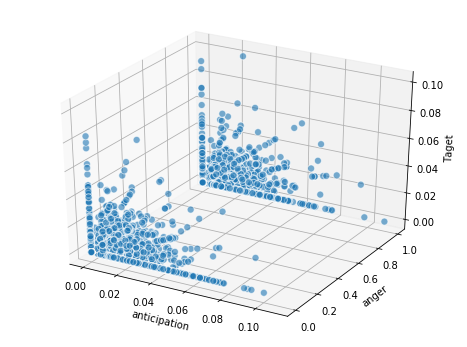

In [121]:
# Visualizing 3-D numeric data with Scatter Plots
# length, breadth and depth
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = FwithT['anticipation']
ys = FwithT['Target']
zs = FwithT['anger']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('anticipation')
ax.set_ylabel('anger')
ax.set_zlabel('Taget')

Text(0.5,0,'Anticipation')

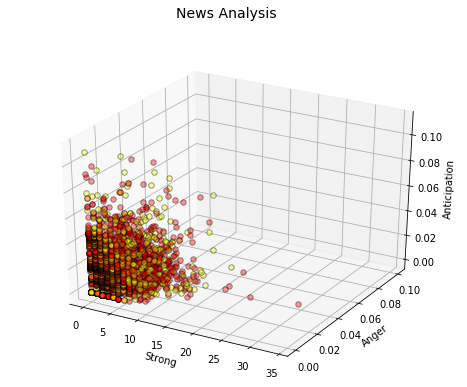

In [122]:
# Visualizing 4-D mix data using scatter plots
# leveraging the concepts of hue and depth
fig = plt.figure(figsize=(8, 6))
t = fig.suptitle('News Analysis', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(FwithT['strong'])
ys = list(FwithT['anger'])
zs = list(FwithT['anticipation'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['red' if wt == 0 else 'yellow' for wt in list(FwithT['Target'])]

for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30)

ax.set_xlabel('Strong')
ax.set_ylabel('Anger')
ax.set_zlabel('Anticipation')

Text(0.5,0,'Anticipation')

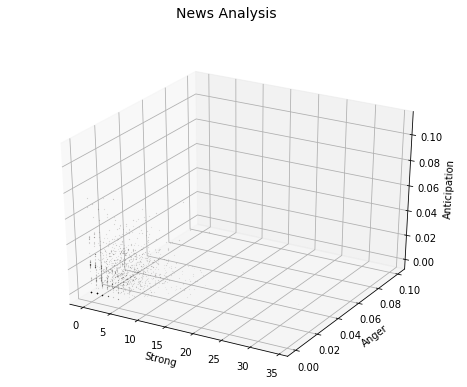

In [123]:

# Visualizing 6-D mix data using scatter charts
# leveraging the concepts of hue, size, depth and shape
fig = plt.figure(figsize=(8, 6))
t = fig.suptitle('News Analysis', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(FwithT['strong'])
ys = list(FwithT['anger'])
zs = list(FwithT['anticipation'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['red' if wt == 0 else 'yellow' for wt in list(FwithT['Target'])]

ss = list(FwithT['sadness'])
colors = ['red' if wt == 0 else 'yellow' for wt in list(FwithT['Target'])]
markers = [',' if q == 'high' else 'x' if q == 'medium' else 'o' for q in list(FwithT['actvie'])]

for data, color, size, mark in zip(data_points, colors, ss, markers):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=size, marker=mark)

ax.set_xlabel('Strong')
ax.set_ylabel('Anger')
ax.set_zlabel('Anticipation')

## Bert for DataProcessing

In [7]:
import numpy as np 
import pandas as pd
import re
import gc
import os
import fileinput
import string
# import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [8]:
bertDf = pd.read_csv('nw_feature_MSFT.csv')
targetDF_ = pd.read_csv('nw_lag_MSFT.csv')


In [9]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text


In [10]:
def createComparableDataset(_df):
    _df.date = pd.to_datetime(_df.date)
    _df = _df[_df['date'] >= pd.to_datetime('2015/05/04')]
    _df = _df[_df['date'] <= pd.to_datetime('2019/03/28')]
    return _df

In [11]:
bertDf = createComparableDataset(bertDf)

In [12]:
bertDf.head(2)

,date,news_len,lm_positive,HNA_combine_sent,lm_negative,lm_polarity,lm_subjectivity,actvie,passive,weak,...,disgust,anticipation,fear,trust,tb_polarity,tb_subjectivity,hiv4_positive,hiv4_negative,hiv4_polarity,hiv4_subjectivity
353,2016-04-01,723,0,"Week in Review , April 2 .... ● Related news s...",0,0.000000,0.000000,6,1,4,...,0.0,0.000029,0.0,0.0,0.312121,0.882071,9,2,1.833333,0.563030
354,2018-04-01,245,0,Only one outcome for the tech acronym ...Googl...,1,-0.999999,0.043478,0,0,2,...,0.0,0.000000,0.0,0.0,0.000000,1.000000,1,3,-0.500000,0.173913


In [13]:
bertProcessedText = bertDf['HNA_combine_sent'].progress_apply(clean_text)

100%|█████████████████████████████████████████████████████████████████████████████| 1027/1027 [00:01<00:00, 735.52it/s]


In [14]:
len(bertProcessedText)

1027

In [15]:
#bert-serving-start -model_dir C:/bert/ -num_worker=4
from bert_serving.client import BertClient
bc = BertClient()

In [16]:
bertVectorList = list()
bertVectorList.extend(bc.encode(list(bertProcessedText)))

C:\Users\praveen ji\Anaconda3\envs\tf_gpu\lib\site-packages\bert_serving\client\__init__.py:286: UserWarning: some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


In [17]:
df = pd.DataFrame(bertVectorList)

In [18]:
df.to_csv('BertVector.csv', index= False)

## BERT Model

In [3]:
df = pd.read_csv('BertVector.csv')
targetDF_ =pd.read_csv('nw_lag_MSFT.csv')

In [ ]:
def computerConfusionMatrixAndAccuracy(featureDF , targetDF):
    for index in list(targetDF):
        train_features, test_features, train_labels, test_labels= model_selection.train_test_split( featureDF , targetDF[index], test_size=0.1, random_state=0)

        rf_model =RandomForestClassifier(n_estimators=5000, max_depth=4,random_state=0)
        rf_model.fit(train_features, train_labels)
        y_predicted=rf_model.predict(test_features)
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++' )
        print('For Lag:', index)
        
        print('confusion_matrix',confusion_matrix(y_true=test_labels, y_pred=y_predicted))
        print('number of datapoints in Up Class', test_labels.value_counts()[1])
        print('number of datapoints in Down Class', test_labels.value_counts()[0])
        print('accuracy_score',accuracy_score(y_predicted, test_labels))
        print('classification_score\n',classification_report(y_predicted, test_labels))
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [8]:
computerConfusionMatrixAndAccuracy(df , targetDF_)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Lag: Lag1
confusion_matrix [[255   0]
 [147   0]]
number of datapoints in Up Class 147
number of datapoints in Down Class 255
accuracy_score 0.6343283582089553
classification_score               precision    recall  f1-score   support

           0       1.00      0.63      0.78       402
           1       0.00      0.00      0.00         0

   micro avg       0.63      0.63      0.63       402
   macro avg       0.50      0.32      0.39       402
weighted avg       1.00      0.63      0.78       402

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Lag: Lag2
confusion_matrix [[223   0]
 [179   0]]
number of datapoints in Up Class 179
number of datapoints in Down Class 223
accuracy_score 0.554726368159204
classification_score               precision    recall  f1-score   support

           0       1.00      0.55      0.71       402
           1       0.00      0.00      0.00         0

   micro avg       0.55      0.55      0.55       402
   macro avg       0.50      0.28      0.36       402
weighted avg       1.00      0.55      0.71       402

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Lag: Lag3
confusion_matrix [[ 44 152]
 [ 64 142]]
number of datapoints in Up Class 206
number of datapoints in Down Class 196
accuracy_score 0.4626865671641791
classification_score               precision    recall  f1-score   support

           0       0.22      0.41      0.29       108
           1       0.69      0.48      0.57       294

   micro avg       0.46      0.46      0.46       402
   macro avg       0.46      0.45      0.43       402
weighted avg       0.56      0.46      0.49       402

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
For Lag: Lag4
confusion_matrix [[  5 167]
 [  6 224]]
number of datapoints in Up Class 230
number of datapoints in Down Class 172
accuracy_score 0.5696517412935324
classification_score             

## Naive Bayes Classifier - Trust Feature

In [124]:
import numpy as nd
import pandas as pd

In [125]:
featureDF_ = pd.read_csv('nw_feature_MSFT.csv')
targetDF_ = pd.read_csv('nw_lag_MSFT.csv')
TextForProcessing = list(featureDF_['HNA_combine_sent'])
targetArr = nd.array(targetDF_['Lag1'])

In [126]:
print(len(TextForProcessing))
print(len(targetArr))

4020
4020


In [127]:
import sklearn

In [128]:
train_features, test_features, train_labels, test_labels= model_selection.train_test_split( TextForProcessing , targetArr, test_size=0.1, random_state=0)

In [129]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1, 3))
X_train_counts = count_vect.fit_transform(train_features)
X_train_counts.shape

(3618, 535035)

In [130]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3618, 535035)

In [131]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf,train_labels)

In [132]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

text_clf = text_clf.fit(train_features, train_labels)

In [133]:
import numpy as np
predicted = text_clf.predict(test_features)
np.mean(predicted == test_labels)

print('Confusion Matrix\n',confusion_matrix(predicted, test_labels))
print('classification_score\n',classification_report(predicted, test_labels))

Confusion Matrix
 [[235 167]
 [  0   0]]
classification_score
               precision    recall  f1-score   support

           0       1.00      0.58      0.74       402
           1       0.00      0.00      0.00         0

   micro avg       0.58      0.58      0.58       402
   macro avg       0.50      0.29      0.37       402
weighted avg       1.00      0.58      0.74       402



C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [134]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))])

text_clf_svm = text_clf_svm.fit(train_features,train_labels)
predicted_svm = text_clf_svm.predict(test_features)
np.mean(predicted_svm == test_labels)
print('confusion_matrix\n',confusion_matrix(predicted, test_labels))
print('classification_score\n',classification_report(predicted, test_labels))

confusion_matrix
 [[235 167]
 [  0   0]]
classification_score
               precision    recall  f1-score   support

           0       1.00      0.58      0.74       402
           1       0.00      0.00      0.00         0

   micro avg       0.58      0.58      0.58       402
   macro avg       0.50      0.29      0.37       402
weighted avg       1.00      0.58      0.74       402



C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [135]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}

In [136]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_features, train_labels)

C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [137]:
gs_clf.best_score_
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}

In [138]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(train_features, train_labels)


gs_clf_svm.best_score_
gs_clf_svm.best_params_

C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\praveen ji\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'clf-svm__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

In [139]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB())])

In [140]:
import nltk
# nltk.download()

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('mnb', MultinomialNB(fit_prior=False))])

text_mnb_stemmed = text_mnb_stemmed.fit(train_features, train_labels)

predicted_mnb_stemmed = text_mnb_stemmed.predict(test_features)


print('accuracy: ', np.mean(predicted_mnb_stemmed == test_labels))
print('classification_score\n',classification_report(predicted_mnb_stemmed, test_labels))

accuracy:  0.5796019900497512
classification_score
               precision    recall  f1-score   support

           0       0.99      0.58      0.73       398
           1       0.01      0.25      0.01         4

   micro avg       0.58      0.58      0.58       402
   macro avg       0.50      0.42      0.37       402
weighted avg       0.98      0.58      0.73       402



## WordCloud

In [4]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import numpy as np
import matplotlib.pyplot as plt

In [11]:
upList = targetDF_['Lag1']
FwithT = featureDF_.copy()
FwithT['Target'] = upList

In [6]:
#wordcloud.to_file("img/first_review.png")

In [12]:

words = "-".join(FwithT.loc[FwithT['Target'] == 1]['HNA_combine_sent'].tolist()[50])
mask = np.array(Image.open('thumbs_up.png'))

# This function takes in your text and your mask and generates a wordcloud. 
def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', collocations = False, stopwords=STOPWORDS, mask=mask).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
#Run the following to generate your wordcloud
generate_wordcloud(words, mask)

KeyError: 'HNA_combine_sent'

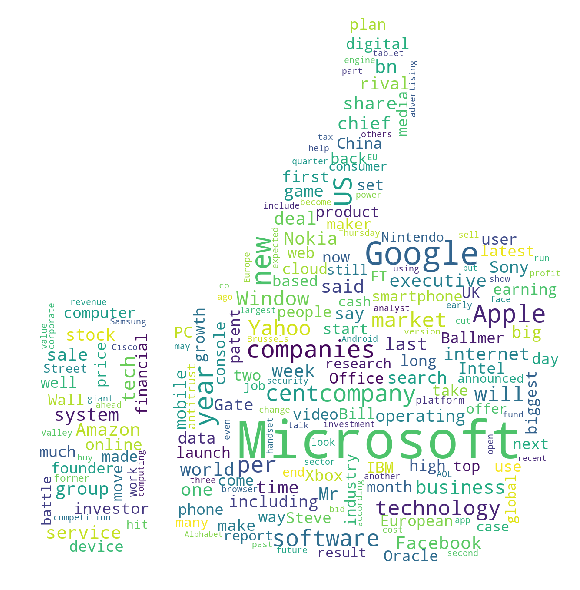

In [7]:

words = "-".join(FwithT.loc[FwithT['Target'] == 1]['HNA_combine_sent'].tolist())
mask = np.array(Image.open('thumbs_up.png'))

# This function takes in your text and your mask and generates a wordcloud. 
def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', collocations = False, stopwords=STOPWORDS, mask=mask).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
#Run the following to generate your wordcloud
generate_wordcloud(words, mask)

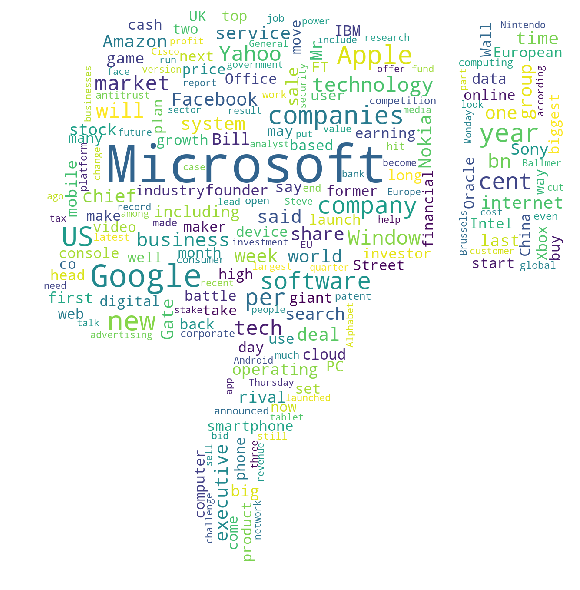

In [8]:

words = "-".join(FwithT.loc[FwithT['Target'] == 0]['HNA_combine_sent'].tolist())
mask = np.array(Image.open('thumbs_up_down.PNG'))

# This function takes in your text and your mask and generates a wordcloud. 
def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', collocations = False, stopwords=STOPWORDS, mask=mask).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    
    plt.show()
    
#Run the following to generate your wordcloud
generate_wordcloud(words, mask)